In [1]:
import findspark
import os
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import correlationfunctions as cr
from scipy.stats import pearsonr, spearmanr
from datetime import datetime
import seaborn as sns


In [2]:
import sys
from pyspark import SparkConf, SparkContext
print(sys.version) 

3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]


import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("select 'spark' as hello ")

df.show()

conf = SparkConf().setMaster('local').setAppName('spark count')
sc = SparkContext(conf = conf)
data = ['data engineering', 'on tuesday']
datardd = sc.parallelize(data)
result = datardd.map(lambda x:x.split(' ')).collect()
result1 = datardd.flatMap(lambda x:x.split(' ')).collect()
print(result)
print(result1)

#4. Websites that I used for this installation:
#https://www.knowledgehut.com/blog/big-data/how-to-install-apache-spark-on-windows
#https://medium.com/big-data-engineering/how-to-install-apache-spark-2-x-in-your-pc-e2047246ffc3

In [3]:
files = os.listdir('C:/Users/Zeno/Google Drive/Data science in Engineering/2IMD15 Data Engineering/data/')
filenames = [file for file in files if file[-4:] == '.txt']

In [4]:
filenames[:5]

['202001_Amsterdam_AALB_NoExpiry.txt',
 '202001_Amsterdam_AGN_NoExpiry.txt',
 '202001_Amsterdam_AKZA_NoExpiry.txt',
 '202001_Amsterdam_APAM_NoExpiry.txt',
 '202001_Amsterdam_ASML_NoExpiry.txt']

In [5]:
# different version of correlation computations

In [6]:
def pearson_greg(in1, in2):
    # Fully custom function
    in1 = in1.array
    in2 = in2.array
    in1_avg = get_average(in1)
    in2_avg = get_average(in2)

    topsum = 0
    blssum = 0
    brssum = 0
    for x in range(len(in1)):
        topsum += (in1[x] - in1_avg) * (in2[x] - in2_avg)
        blssum += (in1[x] - in1_avg)**2
        brssum += (in2[x] - in2_avg)**2

    return topsum / (sqrt(blssum) * sqrt(brssum))

def get_average(dataset):
    # Custom average function
    average = 0
    for x in range(len(dataset)):
        average += dataset[x]
    return average / len(dataset)

def greg_spearman(x, y):
    sum = 0
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    rank1 = rank(x)
    rank2 = rank(y)

    for i in range (n):
        sum += (rank1[i] - rank2[i])**2

    return 1 - (6*sum)/(n*(n*n-1))


# Computes ranks of an array a without accounting for duplicates
def rank_noduplicates(a):
    return sorted(range(len(a)), key=a.__getitem__)


# Computes ranks of an array a and accounts for duplicates
def rank(a):
    n = len(a)
    indeces = rank_noduplicates(a)
    sorted_values = [a[index] for index in indeces]
    duplicates = 0 # number of elements with the same value (1 if no duplicates)
    sum_ranks = 0 # sum of ranks of elements
    ranked = [0]*n # the ranks of the array a
    
    for i in range(n):
        duplicates += 1
        sum_ranks += i

        # If there are no more elements or no more elements with equal values
        if i == n-1 or sorted_values[i] != sorted_values[i+1]:
            # Set rank of elements to the average rank
            average_rank = sum_ranks / float(duplicates) + 1
            for j in range(i - duplicates + 1, i + 1):
                ranked[indeces[j]] = average_rank        
            
            # Clear the counters for the next iteration
            duplicates = 0
            sum_ranks = 0

    return ranked 


In [19]:
from math import sqrt

def correlation(series1, series2, metric='opening', 
                match='omit',duplicates=True, 
                correlation='pearson',showplot=False):
    '''
    series1: a pandas DataFrame
    series2: a pandas DataFrame
    metric: What metric in the data to use (selected from ['date','time','opening','highest','lower','closing','volume'])
    match: how to deal with misalignment of the timeseries
    duplicates: what to do if there are multiple occurences of a date_time in 1 dataframe
    correlation: What correlation coefficient to use
    '''   
    #only keep column you need
    series1 = series1[['date_time',metric]]
    series2 = series2[['date_time',metric]]
    
    #print(series1.head())
    #print(series2.head())
    series1_mask = series1['date_time'].isin(series2['date_time'])
    series2_mask = series2['date_time'].isin(series1['date_time'])
    
    #print(series1_mask.head())
    #print(series2_mask.head())
    
    if match=='omit':
        # only take data that is present in both series
        filt_series1 = series1[series1_mask]
        filt_series2 = series2[series2_mask]
    
    if duplicates==True:
        filt_series1 = filt_series1.drop_duplicates(subset='date_time')
        filt_series2 = filt_series2.drop_duplicates(subset='date_time')
    if showplot==True:
        fig, ax = plt.subplots(figsize=(8,8))
        plt.plot('date_time', metric, '--r',data=series1)
        plt.plot('date_time', metric, '--b',data=series2)
        plt.xticks(rotation=45)
        plt.show()
    
    corr_function = None
    if correlation =='scipy_pearson':
        corr_function = pearsonr
    elif correlation == 'custom_pearson':
        corr_function = cr.pearsonrcustom
    elif correlation == 'pearson_greg':
        corr_function = pearson_greg
    elif correlation == 'scipy_spearman':
        corr_function = spearmanr
    elif correlation == 'custom_spearman':
        corr_function = cr.spearmanrcustom
    elif correlation == 'greg_spearman':
        corr_function = greg_spearman
    start_time = datetime.now()    
    correlations = [corr_function(filt_series1[metric], filt_series2[metric])]
    end_time = datetime.now()
    #print(correlation, end_time-start_time)
    print(correlation, correlations)
    return correlations
               
print(datetime.now())
test1 = pd.read_csv('C:/Users/Zeno/Google Drive/Data science in Engineering/2IMD15 Data Engineering/data/' + filenames[0], sep=",", header=None, 
                                      names=['date','time','opening','highest','lower','closing','volume'],
                                      parse_dates=[['date', 'time']])
test2 = pd.read_csv('C:/Users/Zeno/Google Drive/Data science in Engineering/2IMD15 Data Engineering/data/' + filenames[1], sep=",", header=None,
                      names=['date','time','opening','highest','lower','closing','volume'],
                      parse_dates=[['date', 'time']])

correlation(test1,test2,correlation='scipy_pearson')
correlation(test1,test2,correlation='custom_pearson')
correlation(test1,test2,correlation='pearson_greg')

correlation(test1,test2,correlation='scipy_spearman')
correlation(test1,test2,correlation='custom_spearman')
correlation(test1,test2,correlation='greg_spearman')

print(datetime.now())

2020-05-10 15:40:20.739243
scipy_pearson [(0.4770171571172376, 7.433192538839065e-296)]
custom_pearson [0.477017157117237]
pearson_greg [0.47701715711723813]
scipy_spearman [SpearmanrResult(correlation=0.39989977080969313, pvalue=2.236656602971081e-200)]
custom_spearman [0.399899770809693]
greg_spearman [0.3999277514127969]
2020-05-10 15:40:22.748793


Start:  2020-05-10 15:47:44.565256
202001_NYSE-American_BHB_NoExpiry.txt 202001_NYSE_BAC_NoExpiry.txt


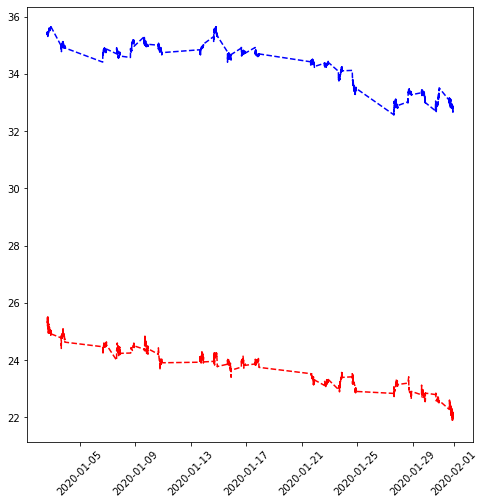

custom_pearson [0.9101339662814337]


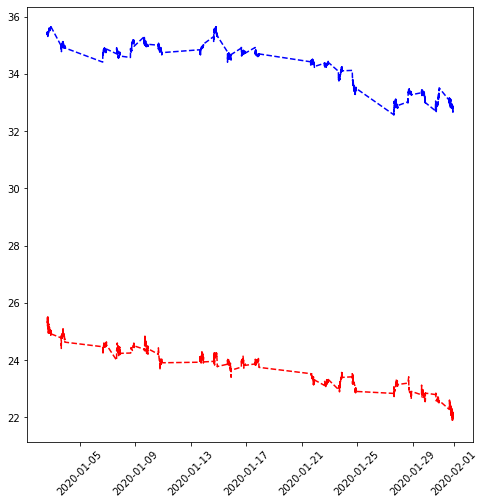

custom_spearman [0.8995825315659136]
202001_NYSE-American_BHB_NoExpiry.txt 202001_NYSE_HDB_NoExpiry.txt


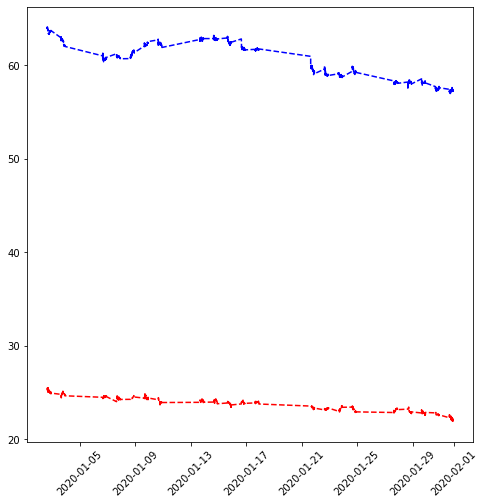

custom_pearson [0.8677962771270925]


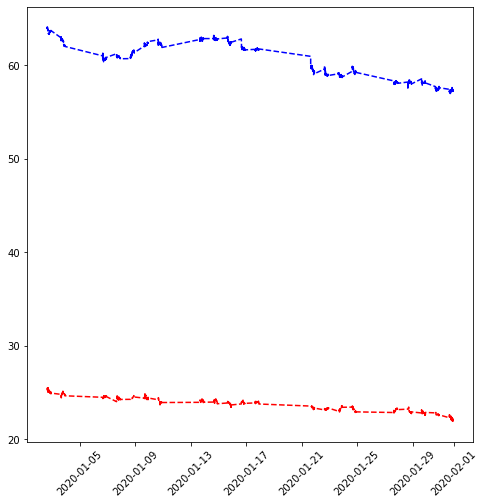

custom_spearman [0.7780674708828919]
202001_NYSE-American_BHB_NoExpiry.txt 202001_NYSE_IBN_NoExpiry.txt


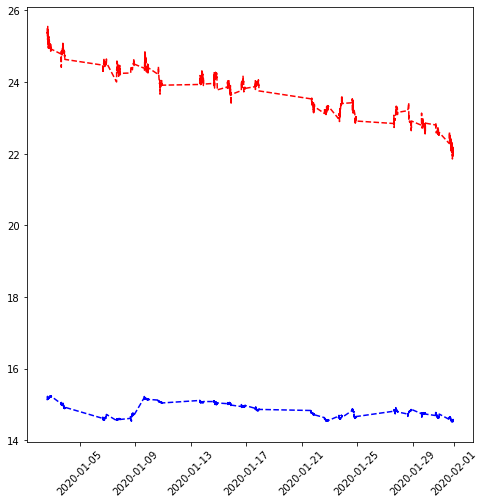

custom_pearson [0.5549844870488223]


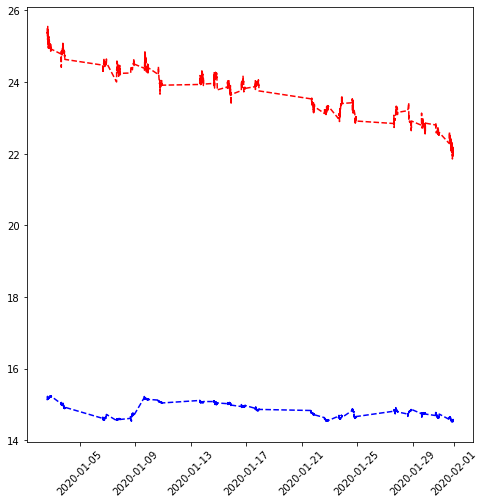

custom_spearman [0.4878465070262164]
202001_NYSE_BAC_NoExpiry.txt 202001_NYSE-American_BHB_NoExpiry.txt


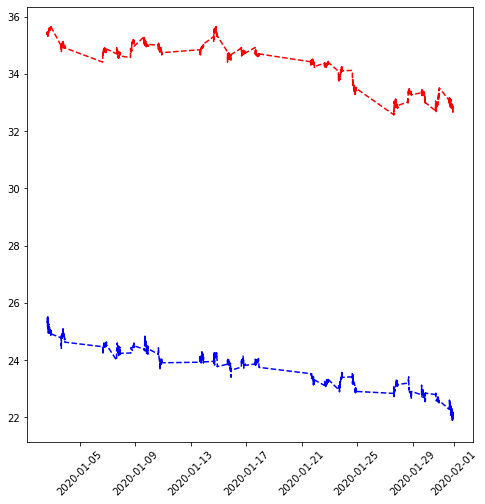

custom_pearson [0.9101339662814337]


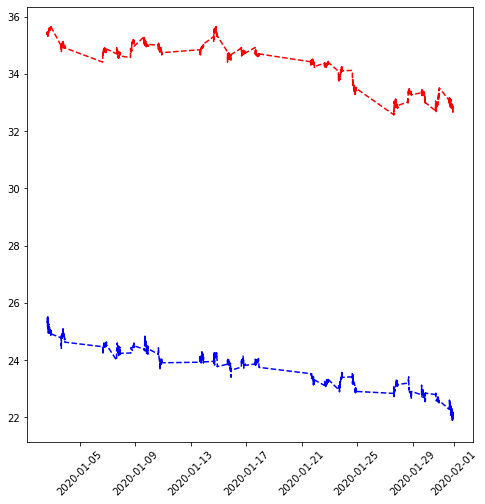

custom_spearman [0.8995825315659136]
202001_NYSE_BAC_NoExpiry.txt 202001_NYSE_HDB_NoExpiry.txt


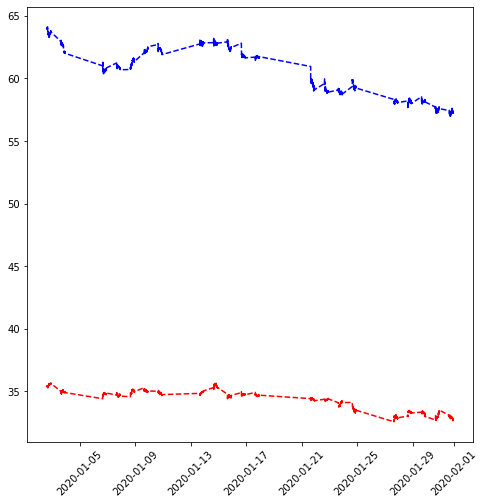

custom_pearson [0.9193743378048105]


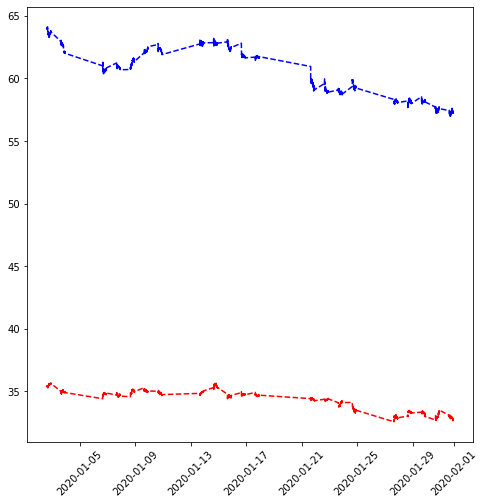

custom_spearman [0.8834908317133215]
202001_NYSE_BAC_NoExpiry.txt 202001_NYSE_IBN_NoExpiry.txt


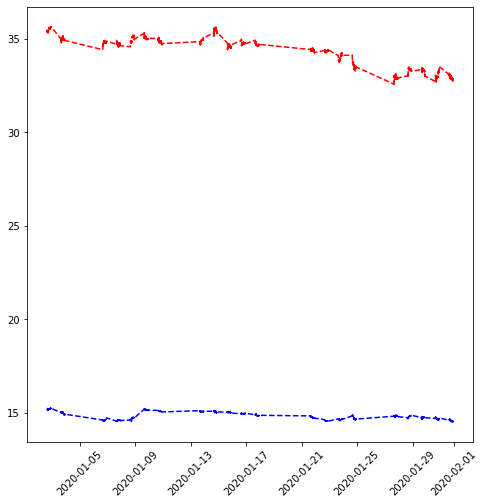

custom_pearson [0.5551388307254222]


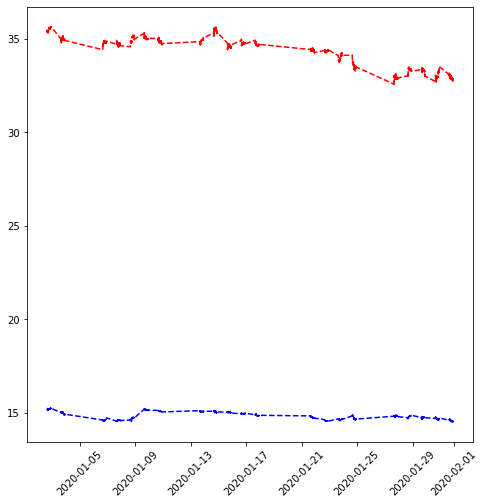

custom_spearman [0.582286435522627]
202001_NYSE_HDB_NoExpiry.txt 202001_NYSE-American_BHB_NoExpiry.txt


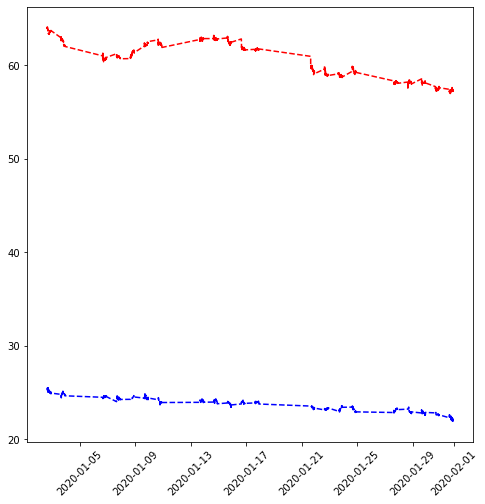

custom_pearson [0.8677962771270925]


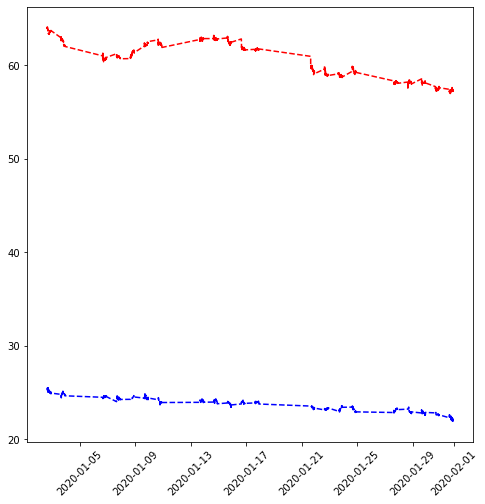

custom_spearman [0.7780674708828919]
202001_NYSE_HDB_NoExpiry.txt 202001_NYSE_BAC_NoExpiry.txt


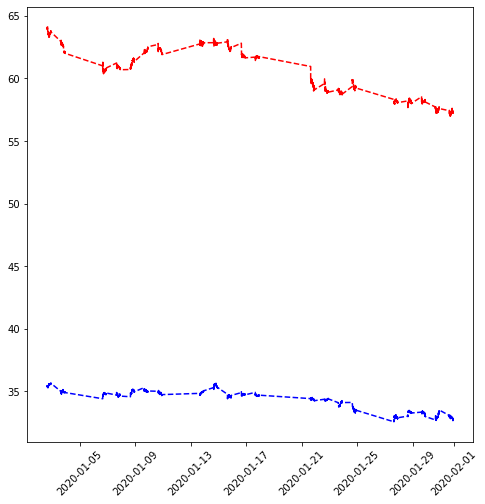

custom_pearson [0.9193743378048105]


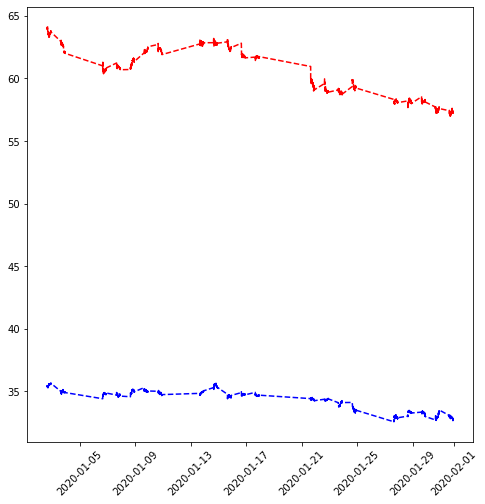

custom_spearman [0.8834908317133215]
202001_NYSE_HDB_NoExpiry.txt 202001_NYSE_IBN_NoExpiry.txt


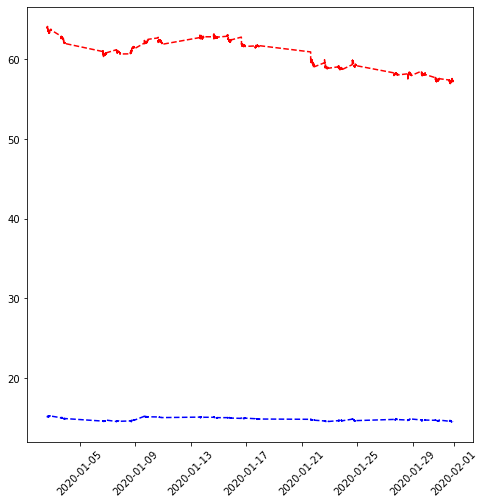

custom_pearson [0.7262682600736505]


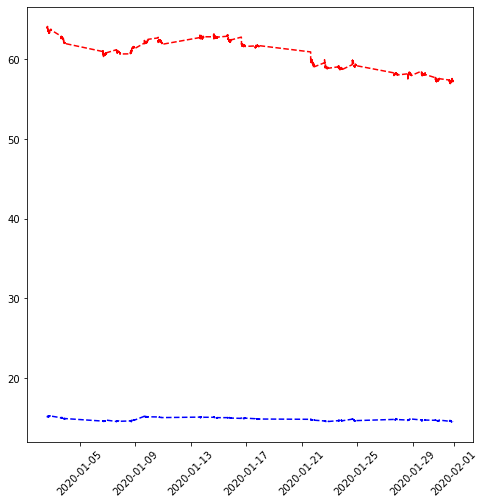

custom_spearman [0.7318808734693288]
202001_NYSE_IBN_NoExpiry.txt 202001_NYSE-American_BHB_NoExpiry.txt


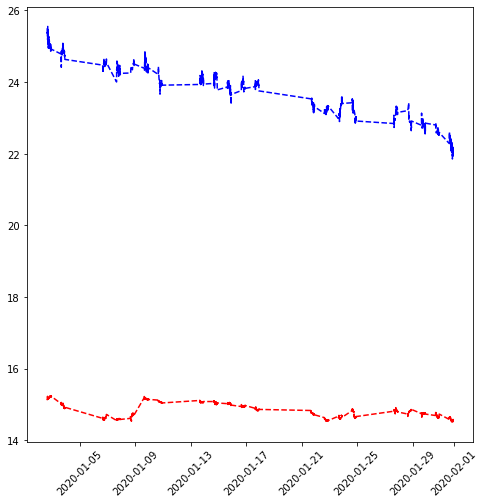

custom_pearson [0.5549844870488223]


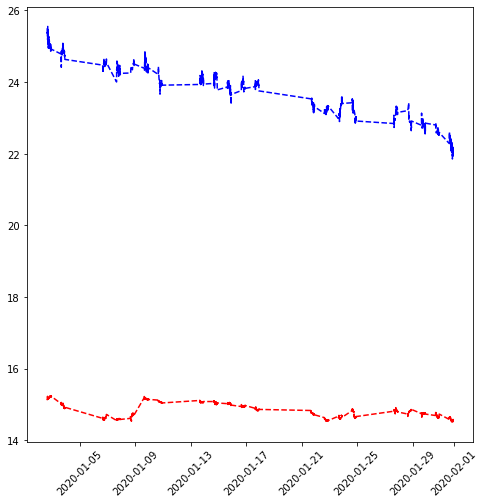

custom_spearman [0.4878465070262164]
202001_NYSE_IBN_NoExpiry.txt 202001_NYSE_BAC_NoExpiry.txt


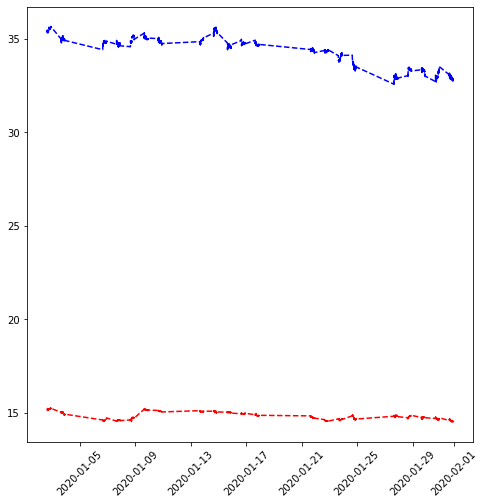

custom_pearson [0.5551388307254222]


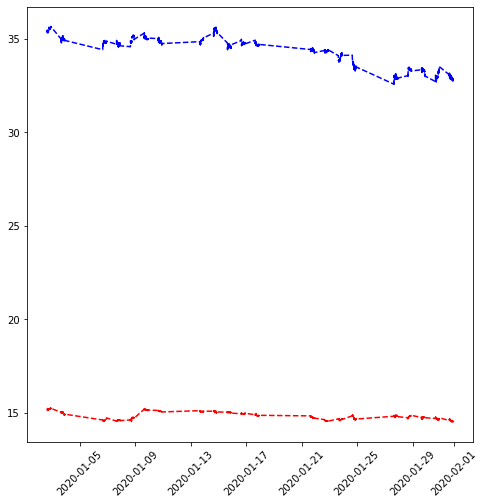

custom_spearman [0.582286435522627]
202001_NYSE_IBN_NoExpiry.txt 202001_NYSE_HDB_NoExpiry.txt


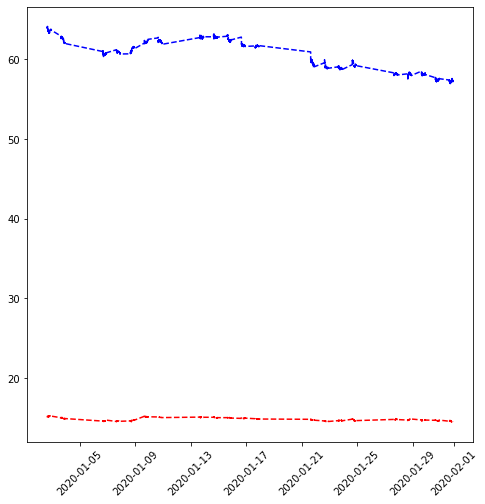

custom_pearson [0.7262682600736505]


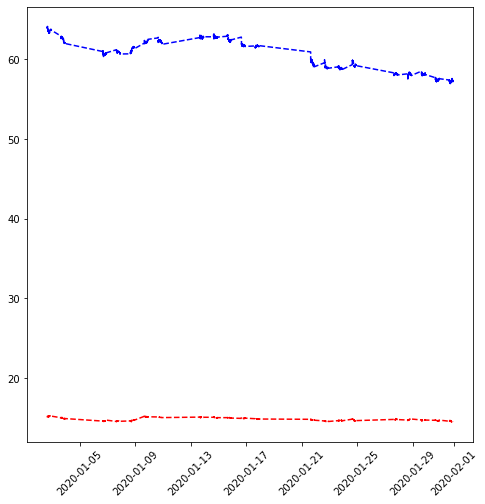

custom_spearman [0.7318808734693288]
End:  2020-05-10 15:48:06.920912


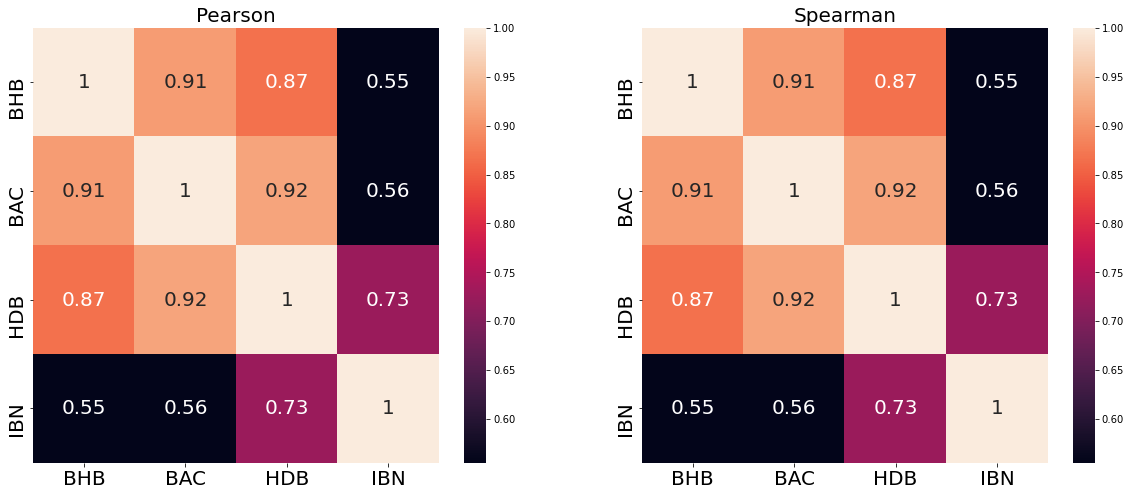

In [24]:
def multi_corr(filelist, showplot=True):
    '''
    filelist: a list with filenames that it needs to analyze and cross reference on correlations.
    '''
    #initialize scores
    pearson = np.ones(shape=(len(filelist), len(filelist)))
    spearman = np.ones(shape=(len(filelist), len(filelist)))
    stocknames = [name.split('_')[2] for name in filelist]
    
    for i, name1 in enumerate(filelist):
        for j, name2 in enumerate(filelist):
            if name1 != name2:
                # TODO
                # Turn it into being compatible with spark, e.g.:
                # df = spark.read.csv("src/main/resources/zipcodes.csv")
                
                series1 = pd.read_csv('C:/Users/Zeno/Google Drive/Data science in Engineering/2IMD15 Data Engineering/data/' + filelist[i], sep=",", header=None, 
                                      names=['date','time','opening','highest','lower','closing','volume'],
                                      parse_dates=[['date', 'time']])
                series2 = pd.read_csv('C:/Users/Zeno/Google Drive/Data science in Engineering/2IMD15 Data Engineering/data/' + filelist[j], sep=",", header=None,
                                      names=['date','time','opening','highest','lower','closing','volume'],
                                      parse_dates=[['date', 'time']])
                
                print(name1, name2)
                pearson[i][j] = correlation(series1, series2, correlation='custom_pearson', showplot=True)[0]
                spearman[i][j] = correlation(series1, series2, correlation='custom_spearman',showplot=True)[0]
                
                #add values to initialized array
                #only interested in correlation, not in corresponding p value
    text_size =  20
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
    sns.heatmap(pearson, annot=True, ax=ax[0], annot_kws={"size":text_size})
    #im = ax[0].imshow(pearson)
    # Loop over data dimensions and create text annotations.
    
    #ax[0].set_xticks(np.arange(len(stocknames)))
    #ax[0].set_yticks(np.arange(len(stocknames)))
    ax[0].tick_params(axis='both', labelsize=text_size)
    ax[0].set_xticklabels(stocknames)
    ax[0].set_yticklabels(stocknames)
    ax[0].set_title("Pearson", fontsize=text_size)
    
    #im = ax[1].imshow(spearman)
    sns.heatmap(pearson, annot=True, ax=ax[1], annot_kws={"size":text_size})
    ax[1].tick_params(axis='both', labelsize=text_size)
    #ax[1].set_xticks(np.arange(len(stocknames)))
    #ax[1].set_yticks(np.arange(len(stocknames)))
    ax[1].set_xticklabels(stocknames)
    ax[1].set_yticklabels(stocknames)
    ax[1].set_title("Spearman", fontsize=text_size)      

    
    
bankfiles = ['202001_NYSE-American_BHB_NoExpiry.txt',
             '202001_NYSE_BAC_NoExpiry.txt',
             '202001_NYSE_HDB_NoExpiry.txt',
             '202001_NYSE_IBN_NoExpiry.txt']

print("Start: ",datetime.now())
multi_corr(bankfiles)
print("End: ", datetime.now())

In [ ]:
from numpy import intersect1d

def prep_for_corr(input1,input2):
    '''
    input1 = [[<dates], [<values>]]
    input2 = [[<dates], [<values>]]
    Computes data based on values for which the date is present in both inputs
    '''
    
    matches, ind_inp1, ind_inp2, matching_dates = np.intersect1d(input1[0], input2[0], return_indices=True)
    series1 = np.array(input1[1])[ind_inp1]
    series2 = np.array(input2[1])[ind_inp2]
    return series1, series2
    
    

In [11]:
a = np.array([0,1,2,3,4,5])
b = np.array([1,2,3,4,5,6])

a-b

array([-1, -1, -1, -1, -1, -1])

In [59]:
a = []
b = []

print(datetime.now())
for i in range(0,100000):
    a.append(i)
print(datetime.now())
b = [i for i in range(0,100000)]
print(datetime.now())

2020-05-09 16:44:06.754139
2020-05-09 16:44:06.766109
2020-05-09 16:44:06.771095


In [69]:
a = np.array([0, 0, 0, 1, 1, 1, 1])
b = np.arange(7)
pearsonrcustom(a,b)

[-0.57142857 -0.57142857 -0.57142857  0.42857143  0.42857143  0.42857143
  0.42857143] [-0.57142857  0.42857143  1.42857143  2.42857143  3.42857143  4.42857143
  5.42857143] 1.3093073414159542 8.323804075404123


(0.5505386303477302, 0)

In [70]:
a = [1, 2, 3, 4, 5]
b = [10, 9, 2.5, 6, 4]
pearsonrcustom(a,b)

[-2. -1.  0.  1.  2.] [ 7.   6.  -0.5  3.   1. ] 3.1622776601683795 9.759610647971568


(-0.48602517675625084, 0)